# 1. Setup

In [ ]:
# Download
!pip install torchmetrics
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [ ]:
# Import
import os, json, random, numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from collections import defaultdict
import time

from torch.optim import SGD, AdamW

from torch.utils.data import SequentialSampler

In [ ]:
# Path of dataset
# You can splitted dataset from this Google Drive link: https://drive.google.com/drive/folders/104kLA0qCfb34YdKFjVk83GFNngkyBkcJ?usp=drive_link
TRAIN_DIR = "/content/drive/MyDrive/[USYD] DATA5703 CS05-2/Dataset of MOANA/single_island/X_band_label_train"
VAL_DIR   = "/content/drive/MyDrive/[USYD] DATA5703 CS05-2/Dataset of MOANA/single_island/X_band_label_val"
TEST_DIR  = "/content/drive/MyDrive/[USYD] DATA5703 CS05-2/Dataset of MOANA/single_island/X_band_label_test"

# 2. Define the Data

In [ ]:
class MyDetectionDataset(Dataset):
    def __init__(self, root: str, transforms=None):
        self.root = Path(root)
        self.transforms = transforms
        self.imgs = sorted([f for f in os.listdir(root) if f.lower().endswith(".png")])

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = self.root / img_name
        json_path = self.root / f"{Path(img_name).stem}.json"

        img = Image.open(img_path).convert("RGB")
        with open(json_path) as f:
            data = json.load(f)

        boxes, labels = [], []
        for anno in data.get("annotations", []):
            xmin, ymin = anno["xmin"], anno["ymin"]
            xmax = xmin + anno["width"]
            ymax = ymin + anno["height"]
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(anno["category_id"])

        if not boxes:
            boxes  = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,),   dtype=torch.int64)

        target = {
            "boxes":  torch.as_tensor(boxes,  dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area":     torch.zeros(len(boxes), dtype=torch.float32) if len(boxes)==0 else
                        (torch.tensor(boxes)[:, 3] - torch.tensor(boxes)[:, 1]) *
                        (torch.tensor(boxes)[:, 2] - torch.tensor(boxes)[:, 0]),
            "iscrowd": torch.zeros(len(boxes), dtype=torch.int64),
        }

        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self): return len(self.imgs)

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

class ToTensor:
    def __call__(self, img, target):
        return F.to_tensor(img), target

class RandomFlip:
    def __init__(self, p=0.5): self.p = p

    def __call__(self, img, target):
        if torch.rand(1) < self.p:
            w = img.shape[2]
            img = img.flip(-1)
            boxes = target["boxes"]
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes
        return img, target

def get_transform(train=True):
    tfs = [ToTensor()]
    if train:
        tfs.append(RandomFlip(0.5))
    return Compose(tfs)

def collate_fn(batch):
    imgs, tgts = zip(*batch)
    return list(imgs), list(tgts)

# 3. DataLoader

In [ ]:
train_loader = DataLoader(
    MyDetectionDataset(TRAIN_DIR, get_transform(True)),
    batch_size=2,
    shuffle=False,
    sampler=SequentialSampler(
        MyDetectionDataset(TRAIN_DIR, get_transform(True))
    ),
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    MyDetectionDataset(VAL_DIR, get_transform(False)),
    batch_size=2,
    shuffle=False,
    sampler=SequentialSampler(
        MyDetectionDataset(VAL_DIR, get_transform(False))
    ),
    num_workers=2,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    MyDetectionDataset(TEST_DIR, get_transform(False)),
    batch_size=2,
    shuffle=False,
    sampler=SequentialSampler(
        MyDetectionDataset(TEST_DIR, get_transform(False))
    ),
    num_workers=2,
    collate_fn=collate_fn
)


# 4. Build the Model

In [ ]:
def get_model(num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_feat = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = get_model().to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 233MB/s]


# 5. Train the Model

In [ ]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, SequentialSampler
from torchvision.ops import box_convert
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pathlib import Path
import time
from collections import defaultdict
import math

num_epochs        = 20
train_batch_size  = 4
val_batch_size    = 4
num_workers       = 4
base_lr           = 1e-4
weight_decay      = 1e-4
print_freq        = 50
val_interval      = 1
ckpt_dir          = Path("./checkpoints")
ckpt_dir.mkdir(exist_ok=True)
device            = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(
    MyDetectionDataset(TRAIN_DIR, get_transform(train=True)),
    batch_size=train_batch_size,
    sampler=SequentialSampler(MyDetectionDataset(TRAIN_DIR)),
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_loader = DataLoader(
    MyDetectionDataset(VAL_DIR, get_transform(train=False)),
    batch_size=val_batch_size,
    sampler=SequentialSampler(MyDetectionDataset(VAL_DIR)),
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True,
)

model.to(device)

optimizer = AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=8, gamma=0.1
)

@torch.no_grad()
def evaluate_map(model, data_loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox",
                                  iou_thresholds=None,
                                  class_metrics=False)
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        processed_outputs = []
        for out in outputs:
            processed_outputs.append({
                "boxes": out["boxes"].cpu(),
                "scores": out["scores"].cpu(),
                "labels": out["labels"].cpu(),
            })

        processed_targets = []
        for t in targets:
            processed_targets.append({
                "boxes": t["boxes"].cpu(),
                "labels": t["labels"].cpu(),
            })

        metric.update(processed_outputs, processed_targets)

    metrics = metric.compute()
    map50      = metrics["map_50"].item()
    map5090    = metrics["map"].item()
    return map50, map5090

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    lr = optimizer.param_groups[0]["lr"]
    header = f"Epoch [{epoch}/{num_epochs-1}]"
    running_loss = 0.0
    for iteration, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad(set_to_none=True)
        losses.backward()
        optimizer.step()

        if iteration % print_freq == 0:
            avg_loss = running_loss / (iteration + 1)
            print(f"{header} | iter {iteration}/{len(data_loader)} | "
                  f"lr {lr:.2e} | loss {avg_loss:.4f}")

    return running_loss / len(data_loader)

best_map50 = 0.0
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)

    lr_scheduler.step()

    if epoch % val_interval == 0 or epoch == num_epochs - 1:
        map50, map5090 = evaluate_map(model, val_loader, device)
        print(f"Validation | mAP@0.5: {map50:.4f} | mAP@0.5:0.95: {map5090:.4f}")

        if map50 > best_map50:
            best_map50 = map50
            ckpt_path = ckpt_dir / f"best_epoch_{epoch}_map50_{best_map50:.4f}.pth"
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "map50": map50,
                "map50_95": map5090,
            }, ckpt_path)
            print(f"Saved best checkpoint to {ckpt_path}")

print("Training Finished. Best val mAP@0.5: {:.4f}".format(best_map50))


Epoch [0/19] | iter 0/249 | lr 1.00e-04 | loss 3.8407
Epoch [0/19] | iter 50/249 | lr 1.00e-04 | loss 0.6515
Epoch [0/19] | iter 100/249 | lr 1.00e-04 | loss 0.6497
Epoch [0/19] | iter 150/249 | lr 1.00e-04 | loss 0.6202
Epoch [0/19] | iter 200/249 | lr 1.00e-04 | loss 0.5970
Validation | mAP@0.5: 0.7213 | mAP@0.5:0.95: 0.5303
✨  Saved best checkpoint to checkpoints/best_epoch_0_map50_0.7213.pth
Epoch [1/19] | iter 0/249 | lr 1.00e-04 | loss 0.3078
Epoch [1/19] | iter 50/249 | lr 1.00e-04 | loss 0.3055
Epoch [1/19] | iter 100/249 | lr 1.00e-04 | loss 0.3844
Epoch [1/19] | iter 150/249 | lr 1.00e-04 | loss 0.4000
Epoch [1/19] | iter 200/249 | lr 1.00e-04 | loss 0.4124
Validation | mAP@0.5: 0.7489 | mAP@0.5:0.95: 0.5716
✨  Saved best checkpoint to checkpoints/best_epoch_1_map50_0.7489.pth
Epoch [2/19] | iter 0/249 | lr 1.00e-04 | loss 0.2510
Epoch [2/19] | iter 50/249 | lr 1.00e-04 | loss 0.2752
Epoch [2/19] | iter 100/249 | lr 1.00e-04 | loss 0.3399
Epoch [2/19] | iter 150/249 | lr 1.00

# 6. Visualisation

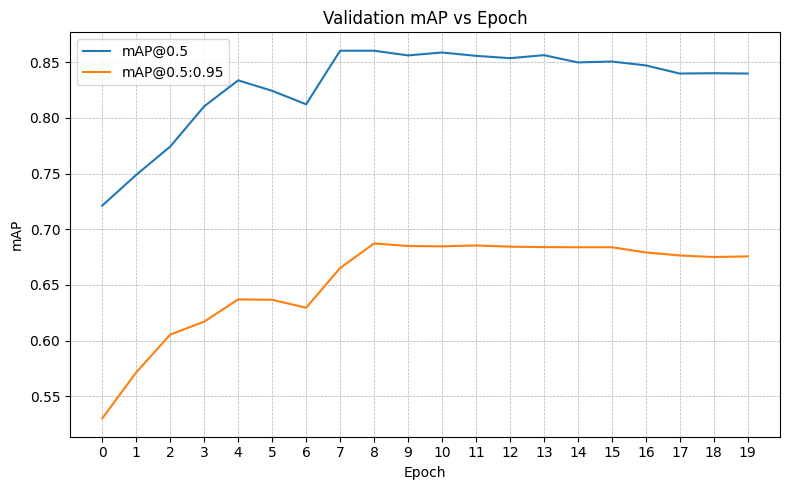

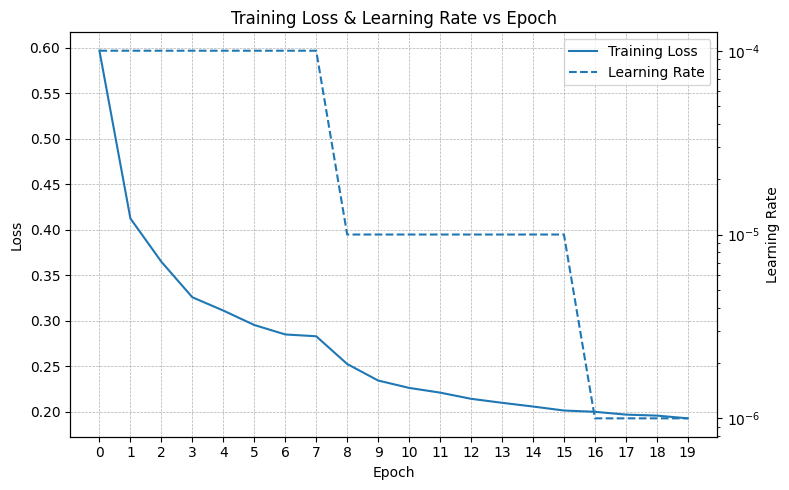

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(20))
map50 = [0.7213, 0.7489, 0.7743, 0.8104, 0.8337, 0.8243, 0.8122, 0.8603, 0.8603, 0.8561,
         0.8587, 0.8557, 0.8536, 0.8563, 0.8498, 0.8506, 0.8471, 0.8398, 0.8401, 0.8398]
map5090 = [0.5303, 0.5716, 0.6055, 0.6171, 0.6371, 0.6367, 0.6296, 0.6652, 0.6873, 0.6850,
           0.6847, 0.6855, 0.6844, 0.6840, 0.6839, 0.6839, 0.6792, 0.6765, 0.6751, 0.6757]

lr = [1e-4]*8 + [1e-5]*8 + [1e-6]*4
loss = [0.5970, 0.4124, 0.3648, 0.3257, 0.3111, 0.2952, 0.2848, 0.2828, 0.2523, 0.2341,
        0.2260, 0.2208, 0.2140, 0.2096, 0.2055, 0.2011, 0.1997, 0.1966, 0.1955, 0.1925]

plt.figure(figsize=(8, 5))
plt.plot(epochs, map50, label='mAP@0.5')
plt.plot(epochs, map5090, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP vs Epoch')
plt.xticks(epochs)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(epochs, loss, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_xticks(epochs)
ax1.grid(True, linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
ax2.plot(epochs, lr, linestyle='--', label='Learning Rate')
ax2.set_ylabel('Learning Rate')
ax2.set_yscale('log')

lines_labels = ax1.get_legend_handles_labels()
lines_labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + lines_labels2[0],
           lines_labels[1] + lines_labels2[1],
           loc='upper right')

plt.title('Training Loss & Learning Rate vs Epoch')
fig.tight_layout()
plt.show()
